In this class, we will talk about model explainability but more in the context of data explainability or root cause analysis. In many cases building a very good machine learning model is not an ultimate goal. What is really wanted is the data understanding. A factory wants to know why the product is plagued with a defect, not to predict afterward if there is a defect or not. A football team wants to know which position is the best for scoring a goal, not what's the probability of scoring from a given position. And even when they want a prediction they would love to see the justification to trust the model. Often a nice plot is worth more than sophisticated machine-learning approaches.

In [1]:
import pandas as pd
import numpy as np
import dalex as dx
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.pipeline import Pipeline
from sklearn_extra.cluster import KMedoids
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import recall_score

In [2]:
data = load_wine()

In [3]:
data
df = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']
df['target'] = y

You should already be familiar with many data visualization techniques so we will not train it now. I just want to share a less popular type of data analysis. Usually plotting the target against any feature is not helpful but after some modification, we might be able to see some patterns. 

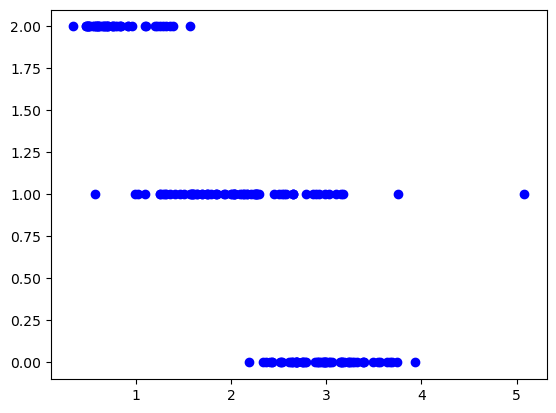

In [4]:
plt.plot(df.flavanoids, y, 'bo')

For each value, we can plot the average target for data:
 - below that value
 - above that value
 - around that value
 
Please note that for the line "above that value" the more left we go the higher fraction of data is covered. The same with the "below that value"

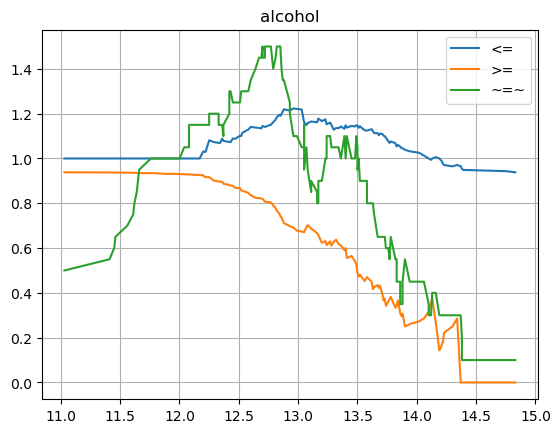

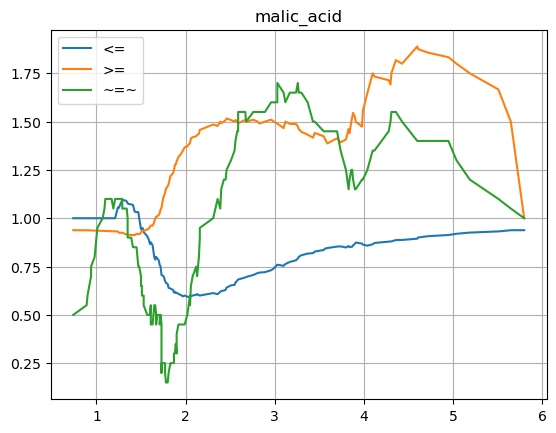

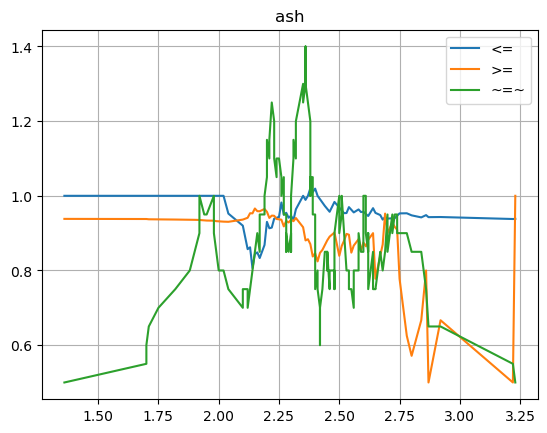

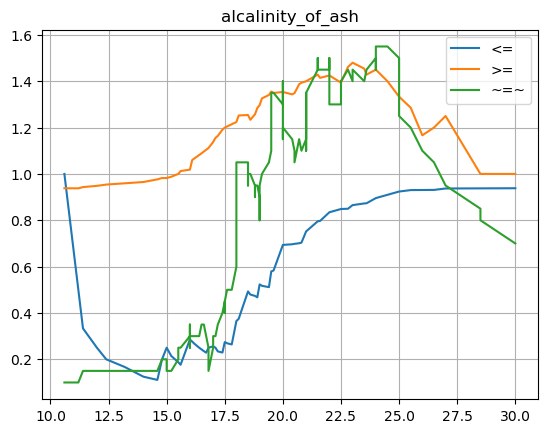

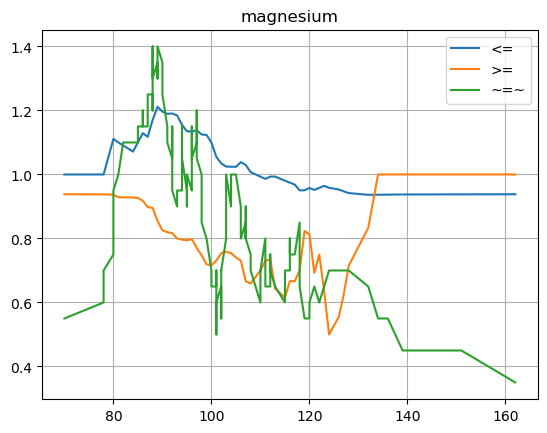

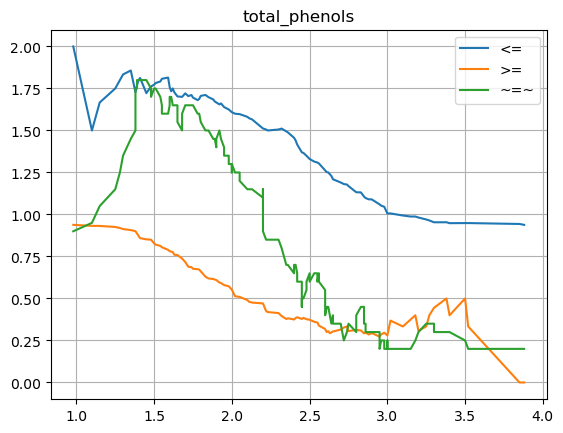

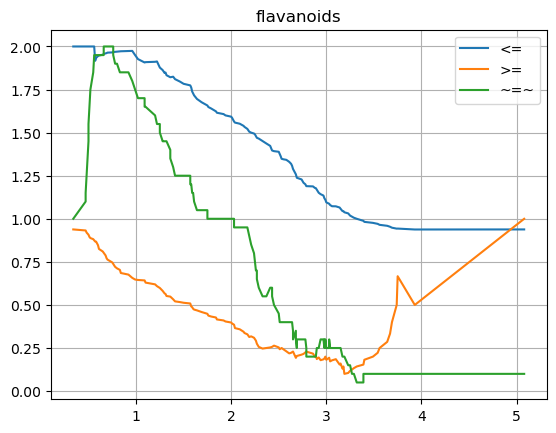

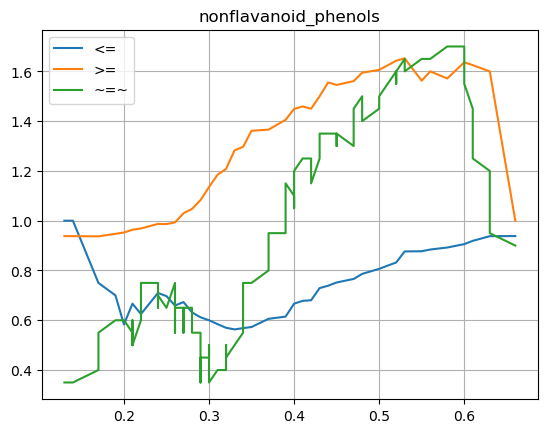

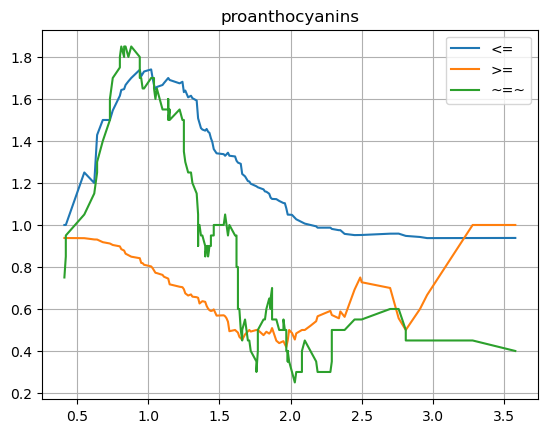

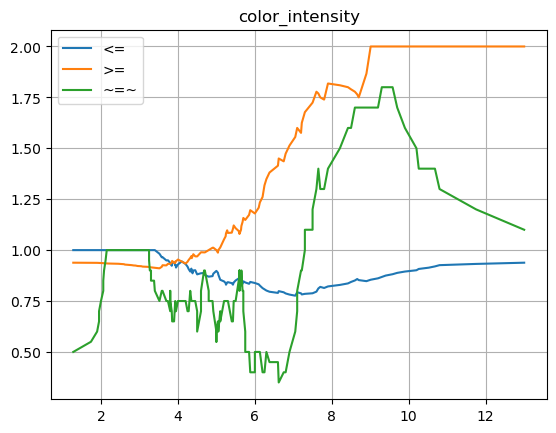

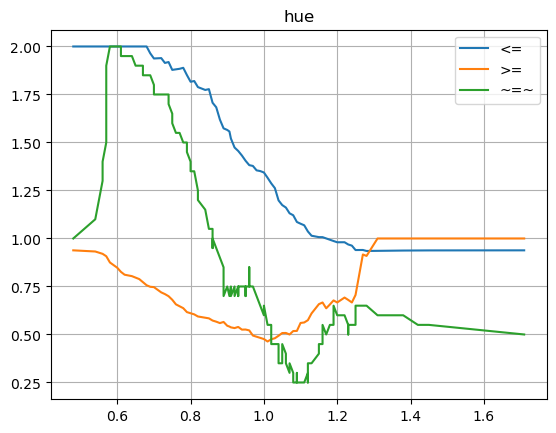

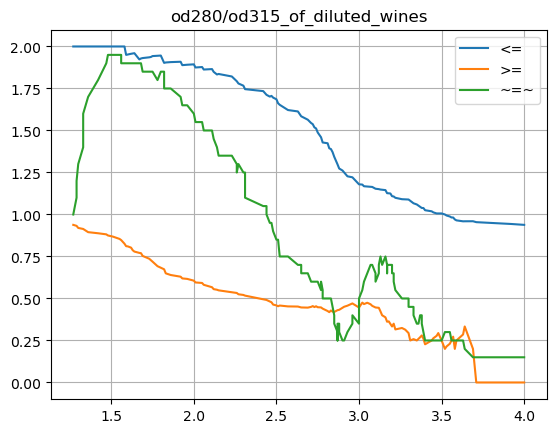

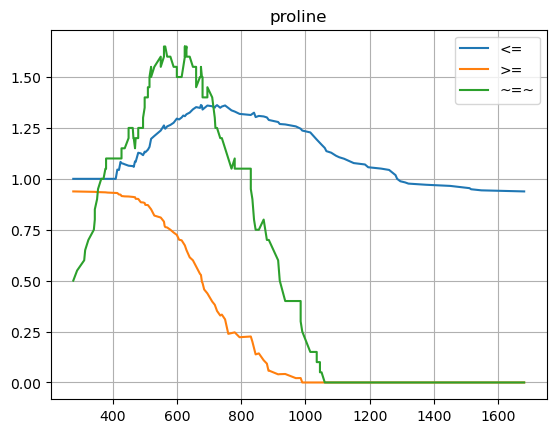

In [5]:
for col in df.columns.drop('target'):
    tmp = df.sort_values(col)
    plt.title(col)
    plt.plot(tmp[col], tmp[col].apply(lambda x: tmp[tmp[col] <= x].target.mean()), label="<=")
    plt.plot(tmp[col], tmp[col].apply(lambda x: tmp[tmp[col] >= x].target.mean()), label=">=")
    plt.plot(tmp[col], np.convolve(np.ones(20)/20, tmp.target, mode='same'), label= "~=~")
    plt.legend()
    plt.grid()
    plt.show()

Ok, let's just train a model. We are not interested in top performance right now so we will skip hyperparameter optimization. Also, we want to find the pattern in the data we have, so we don't split the data into validation and test set.

In [6]:
model = RandomForestRegressor()
x = df.drop('target', axis=1)
y = df.target
model.fit(x, y)

RandomForestRegressor()

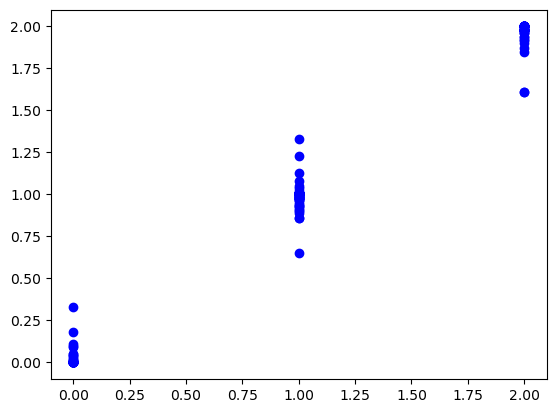

In [7]:
plt.plot(df.target, model.predict(x), 'bo')

Dalex is a python package for model explainability. We will use some of its functions to understand the data and the model better. First, we need to create an explainer model. Since we are not interested in checking the model performance but the relation between the data and the target we will use the whole dataset here. In the first case, we might want to use the testing set.

In [8]:
exp = dx.Explainer(model, x, y)

Preparation of a new explainer is initiated

  -> data              : 178 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 178 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x000001C5A6A9D900> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.931, max = 2.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.33, mean = 0.0073, max = 0.39
  -> model_info        : package sklearn

A new explainer has been created!


In [9]:
fi = exp.model_parts()

The first step will be feature importance. It's a basic analysis where we calculate the global impact of a feature. The idea in dalex default approach is to measure how much the model performance is worsening after removing this feature. Of course, it would require retraining the model, the optimal set of hyperparameters might be different and it might affect the results. To avoid these problems we do not retrain the model. Instead, we simulate its removal by assigning random values to it. To make it more realistic the values are not completely random, we just shuffle this column in a dataframe, do the prediction, check performance and repeat these steps multiple times.

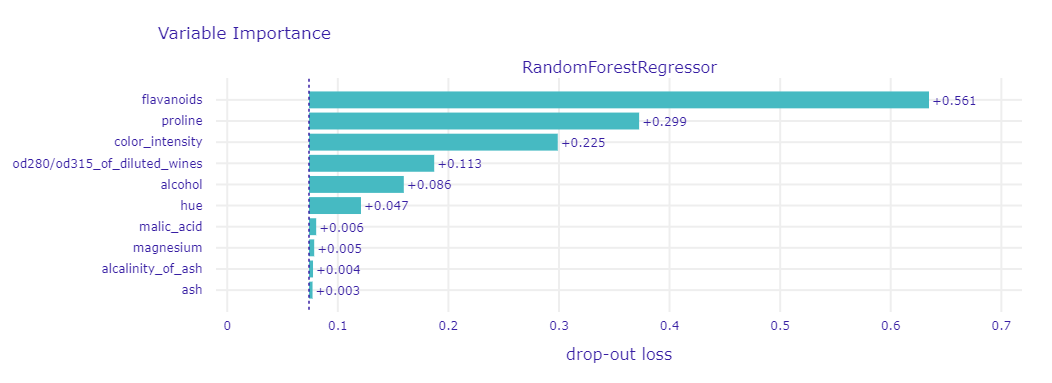

In [10]:
fi.plot()

Another useful tool is a partial dependency plot. For a given feature we observe what's the average output of our model for different values of this feature. For each considered value we set this value for each row in our dataframe and calculate an average prediction.

Calculating ceteris paribus: 100%|█████████████████████████████████████████████████████| 13/13 [00:00<00:00, 20.28it/s]


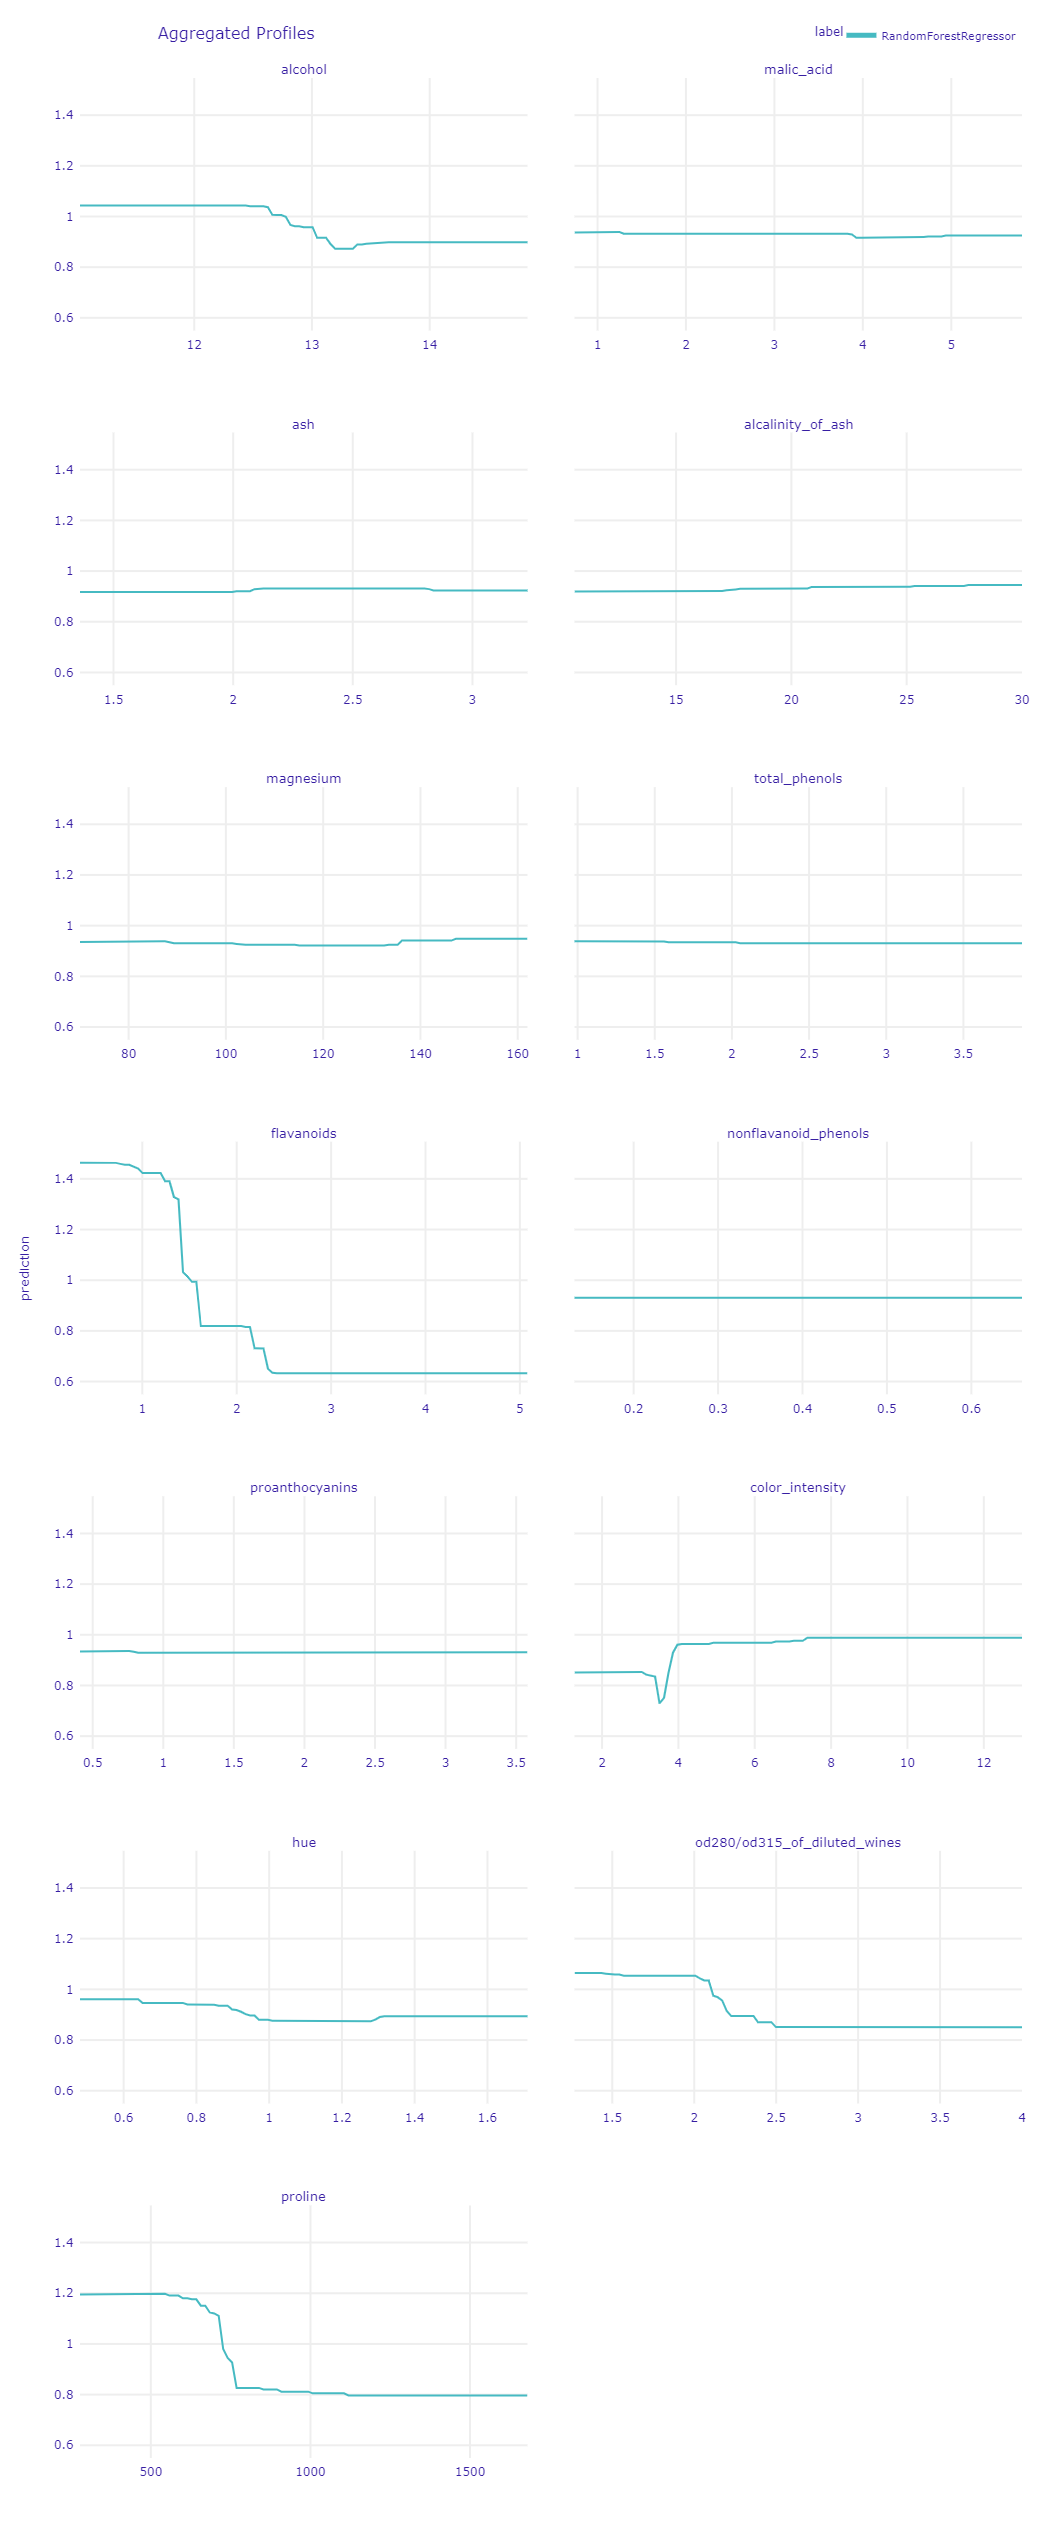

In [11]:
exp.model_profile().plot()


We can also create similar plots for single rows. Here for each column, we present what would be the output from the model assuming we keep all remaining values and change the value of this one selected feature.

Calculating ceteris paribus: 100%|█████████████████████████████████████████████████████| 13/13 [00:00<00:00, 59.43it/s]


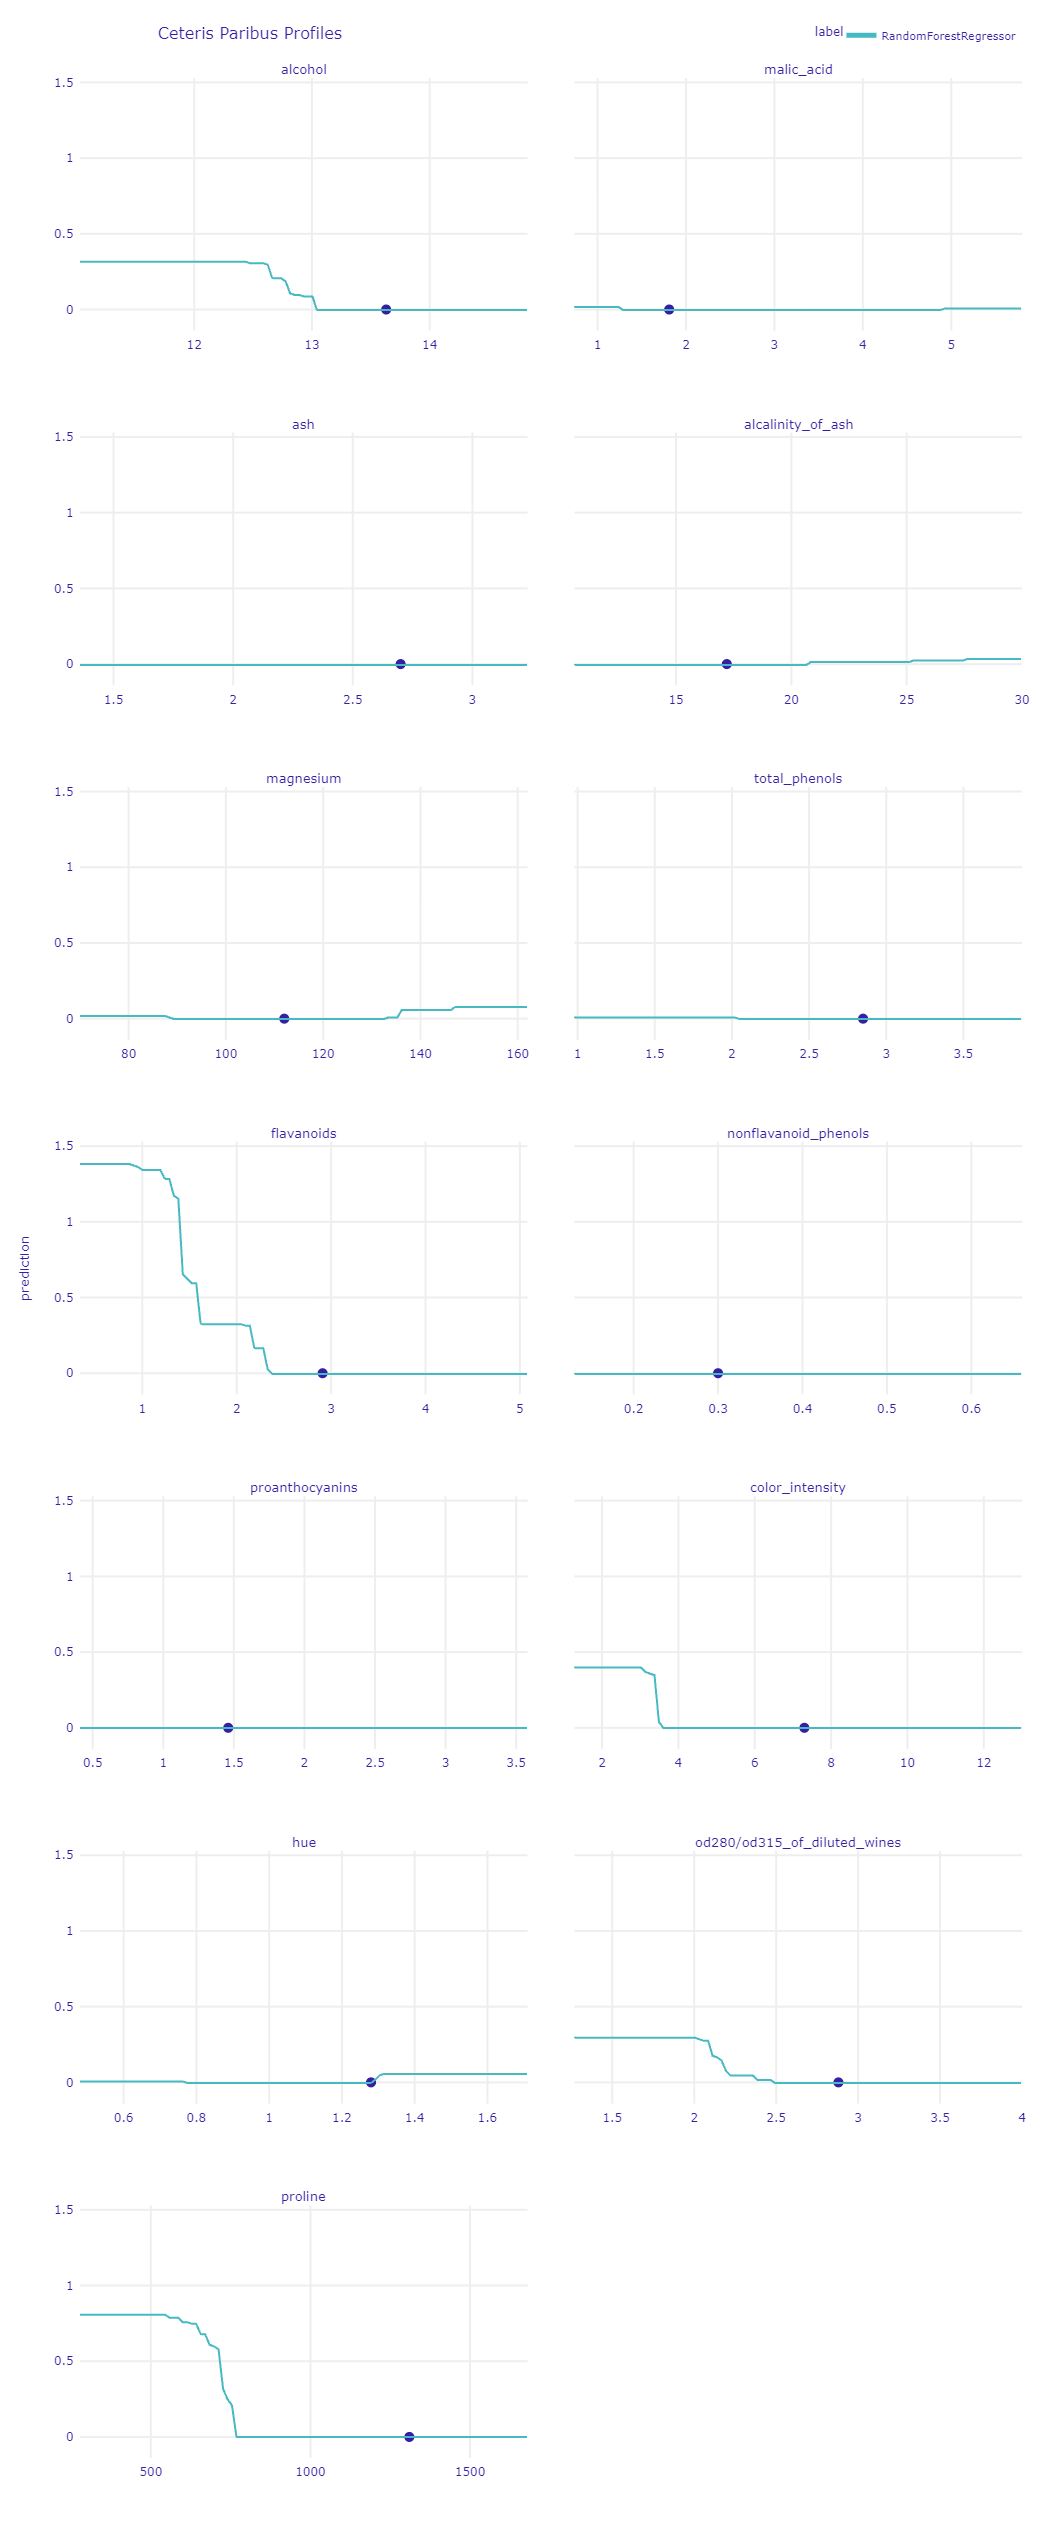

In [12]:
exp.predict_profile(x.iloc[[15]]).plot()

SHAP values are equivalents of Shapley values for the predictive models. It estimates the effect of a particular value of a particular feature for a prediction of a considered row. It's also done by replacing this value with proper sampling and replacing this value and measuring the effect on the prediction.

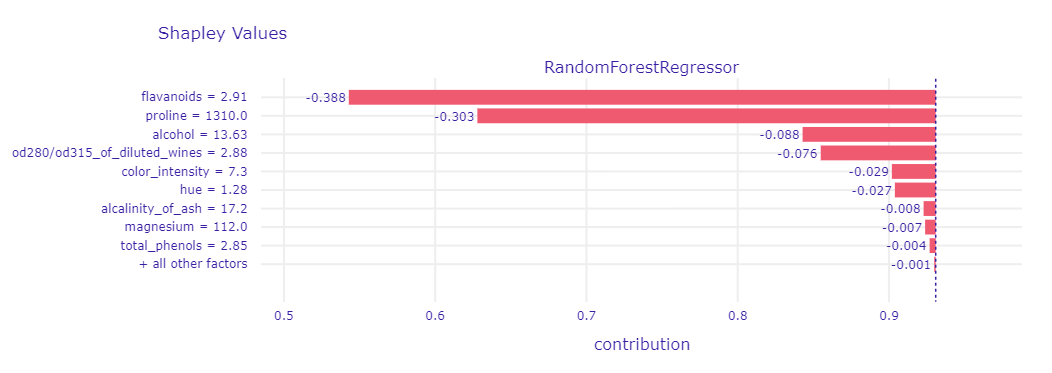

In [13]:
exp.predict_parts(x.iloc[15], type='shap').plot()

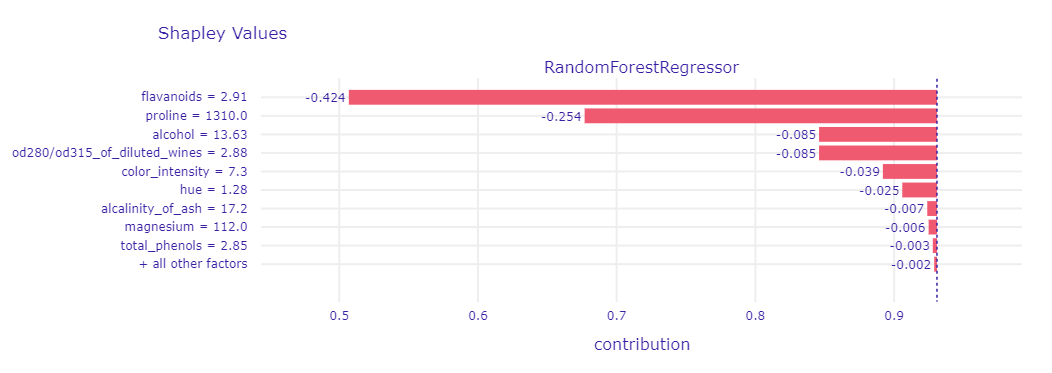

In [14]:
exp.predict_parts(x.iloc[15], type='shap').plot()

The result is based on sampling so the result for the same row can vary

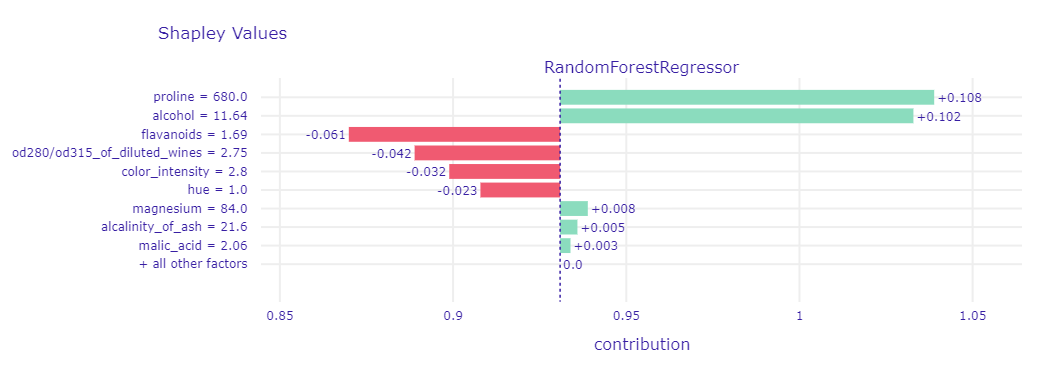

In [15]:
exp.predict_parts(x.iloc[88], type='shap').plot()

In [16]:
exp.predict_parts(x.iloc[88], type='shap').result

variable  contribution         variable_name  \
0      alcalinity_of_ash = 21.6      0.006685     alcalinity_of_ash   
1               alcohol = 11.64      0.112978               alcohol   
2         color_intensity = 2.8     -0.085843       color_intensity   
3              magnesium = 84.0     -0.002022             magnesium   
4             flavanoids = 1.69      0.013539            flavanoids   
..                          ...           ...                   ...   
8             malic_acid = 2.06      0.003499            malic_acid   
9        proanthocyanins = 1.35     -0.002735       proanthocyanins   
10                   ash = 2.46      0.001580                   ash   
11         total_phenols = 1.95      0.000924         total_phenols   
12  nonflavanoid_phenols = 0.48     -0.000261  nonflavanoid_phenols   

    variable_value  sign                  label  B  
0            21.60   1.0  RandomForestRegressor  1  
1            11.64   1.0  RandomForestRegressor  1  
2             2.80  -1.0  RandomForestRegressor  1  
3            84.00  -1.0  RandomForestRegressor  1  
4             1.69   1.0  RandomForestRegressor  1  
..             ...   ...                    ... ..  
8             2.06   1.0  RandomForestRegressor  0  
9             1.35  -1.0  RandomForestRegressor  0  
10            2.46   1.0  RandomForestRegressor  0  
11            1.95   1.0  RandomForestRegressor  0  
12            0.48  -1.0  RandomForestRegressor  0  

[338 rows x 7 columns]

**Task** For each class find the most representative examples and plot breakdown for them.

#### We will find the most representative examples using k-means clustering and taking the closest sample to cluster center (medoid)
#### If just k-means is applied to dataset, results are not the same as target feature. So we firstly split the dataset by target and then look for medoid in each subset

In [17]:
def repres_samples(df):
    df.dropna(inplace=True)
    df_list = [d for _, d in df.groupby(['target'])]   
    medoids = {}
    for d in df_list:
        kmedoids = KMedoids(n_clusters=1, random_state=17)
        kmedoids.fit(d.drop('target', axis=1))
        medoids[d['target'].iloc[0]] = kmedoids.cluster_centers_[0]
    return medoids

In [18]:
medoids = repres_samples(df)

Breakdown for the most representative sample of target 0


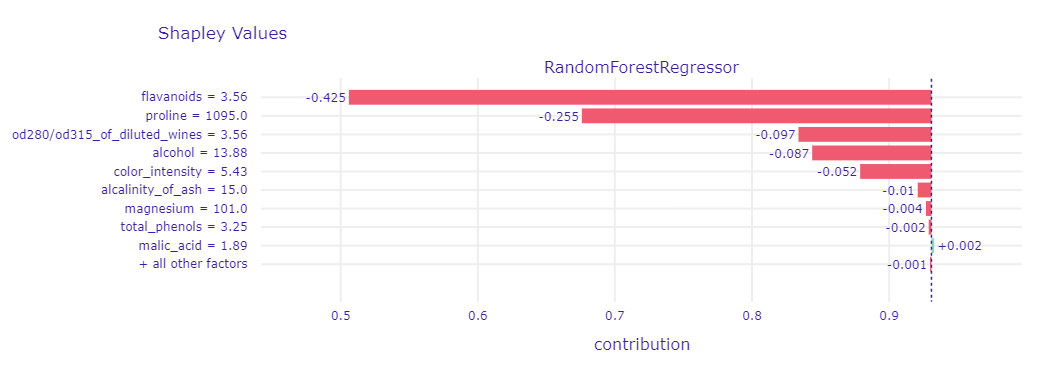

Breakdown for the most representative sample of target 1


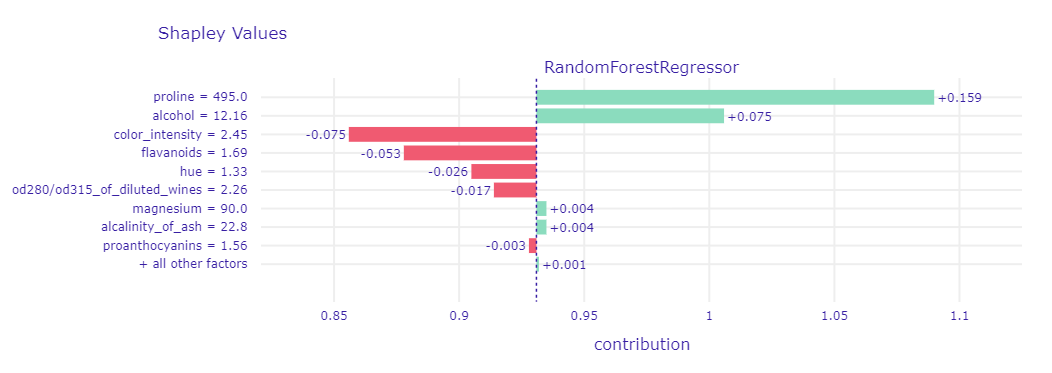

Breakdown for the most representative sample of target 2


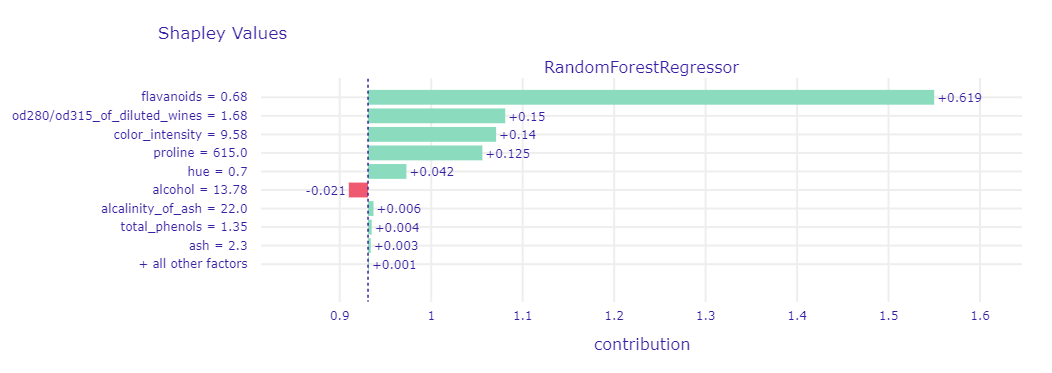

In [19]:
for key in medoids:
    print(f'Breakdown for the most representative sample of target {key}')
    exp.predict_parts(medoids[key], type='shap').plot()

There are other approaches that can be used for model explainability.
 - LIME - approximating model locally by a linear model
 - Anchor - approximating model locally by a rule-based model
 - Prototype - justifying a new prediction by showing a similar known row (a prototype)
 - Counterfactual Explanation - showing a similar know row with a different prediction to show what must be changed to change the prediction.

# Task

- take a dataset you want
- perform an exploratory data analysis (data visualization)
- create a pipeline for data preprocessing
- add new features (one hot encoding for example)
- add predictive model as the last step of the pipeline
- prepare a report with model explainability

Send it to gmiebs@cs.put.poznan.pl within 144 hours after the class is finished. Start the subject of the email with [IR]

Team members: 
- Sofya Aksenyuk, 150284;
- Uladzimir Ivashka, 150281.

## Dataset
##### source: https://www.kaggle.com/datasets/muhammad4hmed/monkeypox-patients-dataset

In [20]:
df = pd.read_csv("DATA.csv")

In [21]:
df.drop(['Patient_ID'], axis=1, inplace=True)
df.rename(columns={'MonkeyPox': 'target'}, inplace=True)

In [22]:
df.head(3)

Systemic Illness  Rectal Pain Sore Throat  Penile Oedema Oral Lesions  \
0             None        False        True           True         True   
1            Fever         True       False           True         True   
2            Fever        False        True           True        False   

  Solitary Lesion Swollen Tonsils HIV Infection  \
0           False            True         False   
1           False           False          True   
2           False           False          True   

  Sexually Transmitted Infection    target  
0                          False  Negative  
1                          False  Positive  
2                          False  Positive

## Exploratory data analysis

In [23]:
df.describe().T

count unique       top   freq
Systemic Illness                24999      4     Fever   6381
Rectal Pain                     25000      2     False  12655
Sore Throat                     24998      2      True  12553
Penile Oedema                   25000      2      True  12612
Oral Lesions                    24995      2     False  12512
Solitary Lesion                 24997      2      True  12525
Swollen Tonsils                 24995      2      True  12531
HIV Infection                   24999      2      True  12584
Sexually Transmitted Infection  24999      2     False  12553
target                          25000      2  Positive  15909

In [24]:
print(f'Missing values: {sum(df.isna().sum()) + sum(df.isnull().sum())} ')
print(f'Number of duplicates: {df.shape[0] - df.drop_duplicates().shape[0]} ')

Missing values: 36 
Number of duplicates: 22944 


### Note: Since a sample (i.e., row) is a patient, in our case, we cannot get rid of the duplicates. Duplicates - simply mean that these patients have similar symptoms; high percentage of duplicates - the superiority of these symptoms. 

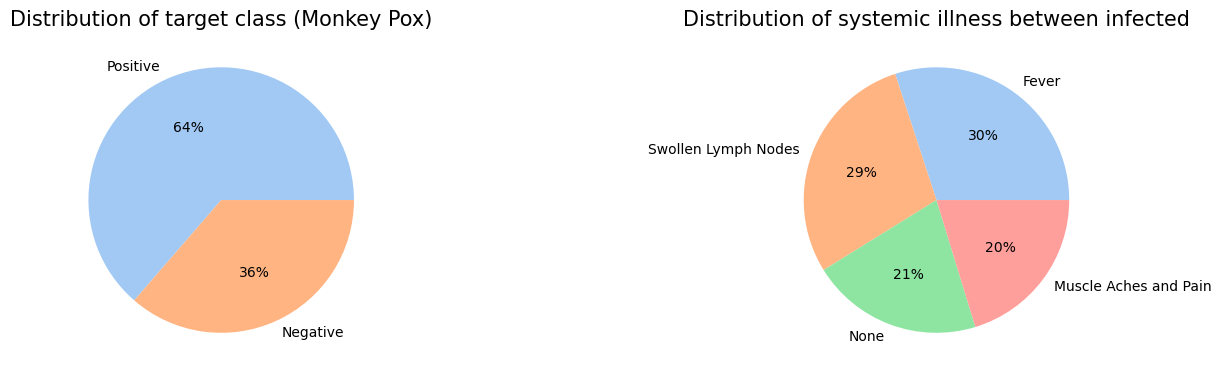

In [25]:
palette = sns.color_palette('pastel')
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.tight_layout(pad=5)

target_dist = df['target'].value_counts()
ax[0].pie(x=target_dist.values, labels=target_dist.index, colors=palette, autopct='%.0f%%')
ax[0].set_title('Distribution of target class (Monkey Pox)', fontsize=15);

illness_dist = df[df['target'] == 'Positive']['Systemic Illness'].value_counts()
ax[1].pie(x=illness_dist.values, labels=illness_dist.index, colors=palette, autopct='%.0f%%')
ax[1].set_title('Distribution of systemic illness between infected', fontsize=15);

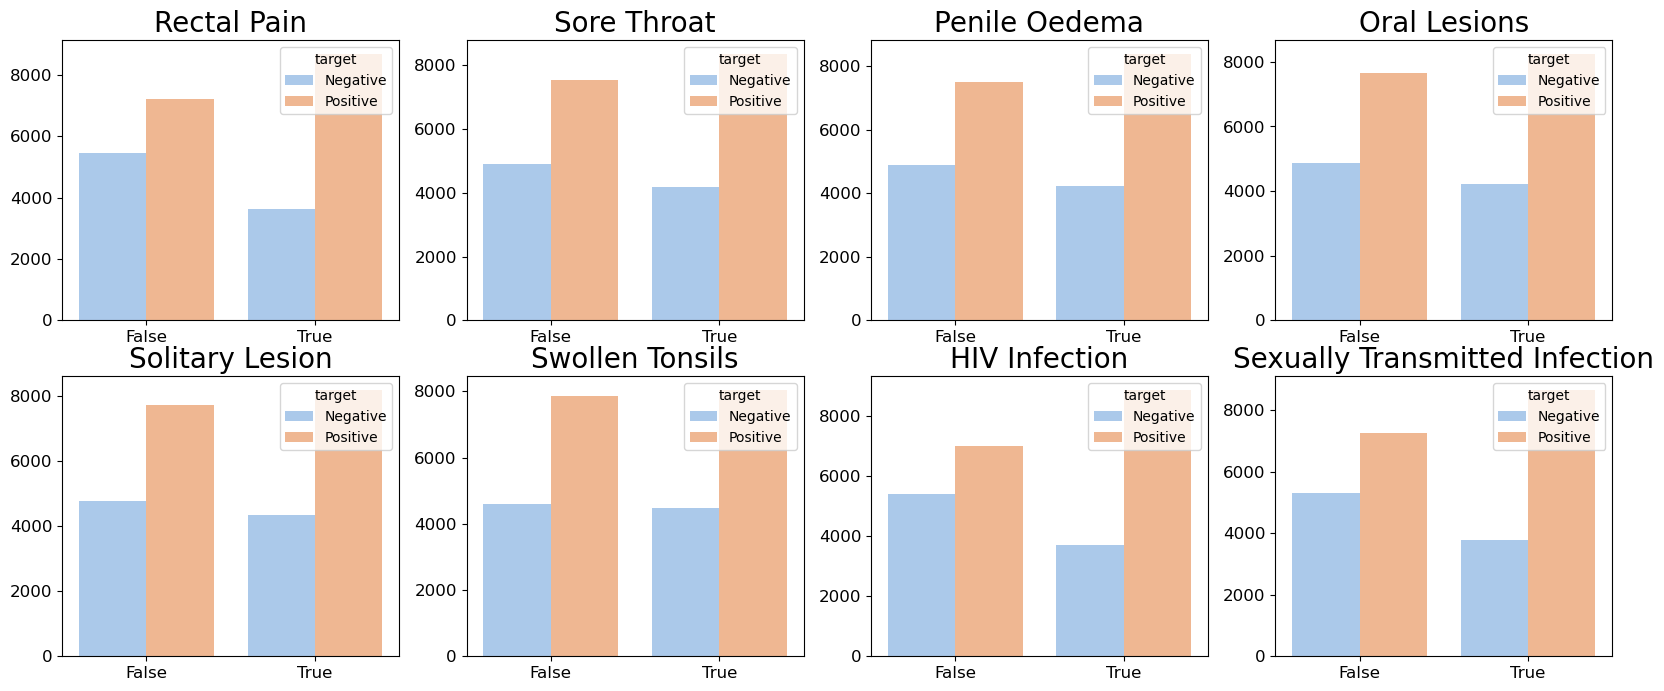

In [26]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
ax = ax.flatten()
for idx, feature in enumerate(df.columns.drop(['target', 'Systemic Illness'])):
    sns.countplot(x=feature, hue='target', data=df, palette=palette, ax=ax[idx])
    ax[idx].set_title(feature, fontsize=20)
    ax[idx].set(ylabel=None, xlabel=None)
    ax[idx].tick_params(axis='both', labelsize=12)

## Model explainability

In [27]:
df_enc = pd.DataFrame(OrdinalEncoder().fit_transform(df), columns=df.columns)

In [28]:
x, y = df_enc.drop('target', axis=1), df_enc['target']

In [29]:
pipe = Pipeline( [ ('Imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), ('RandomForestClassifier', RandomForestClassifier(random_state=17)) ] )
pipe.fit(x, y)

Pipeline(steps=[('Imputer', SimpleImputer(strategy='most_frequent')),
                ('RandomForestClassifier',
                 RandomForestClassifier(random_state=17))])

### Firstly, OrdinalEncoder was used to cast the features into numerical form. Then, the Pipeline consisting of SimpleImputer to replace all the missing values, followed by RandomForestClassifier as the ML model.

In [30]:
exp = dx.Explainer(pipe, x,  y)

Preparation of a new explainer is initiated

  -> data              : 25000 rows 9 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 25000 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001C5A6A9DB40> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.636, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.971, mean = 4.9e-05, max = 0.963
  -> model_info        : package sklearn

A new explainer has been created!


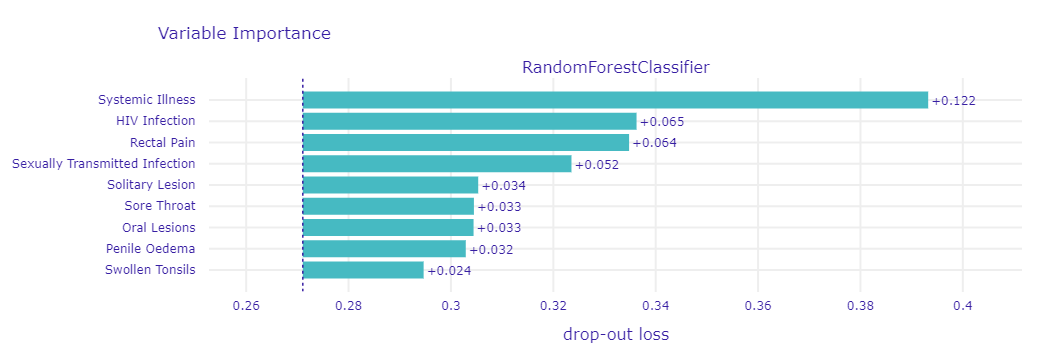

In [31]:
exp.model_parts().plot()

### It can be noticed, that `Systemic Illness` has very big impact. Then, `Rectal Pain`, `HIV Infection` and `Sexually Transmitted Infection`, etc.

Calculating ceteris paribus: 100%|███████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.58it/s]


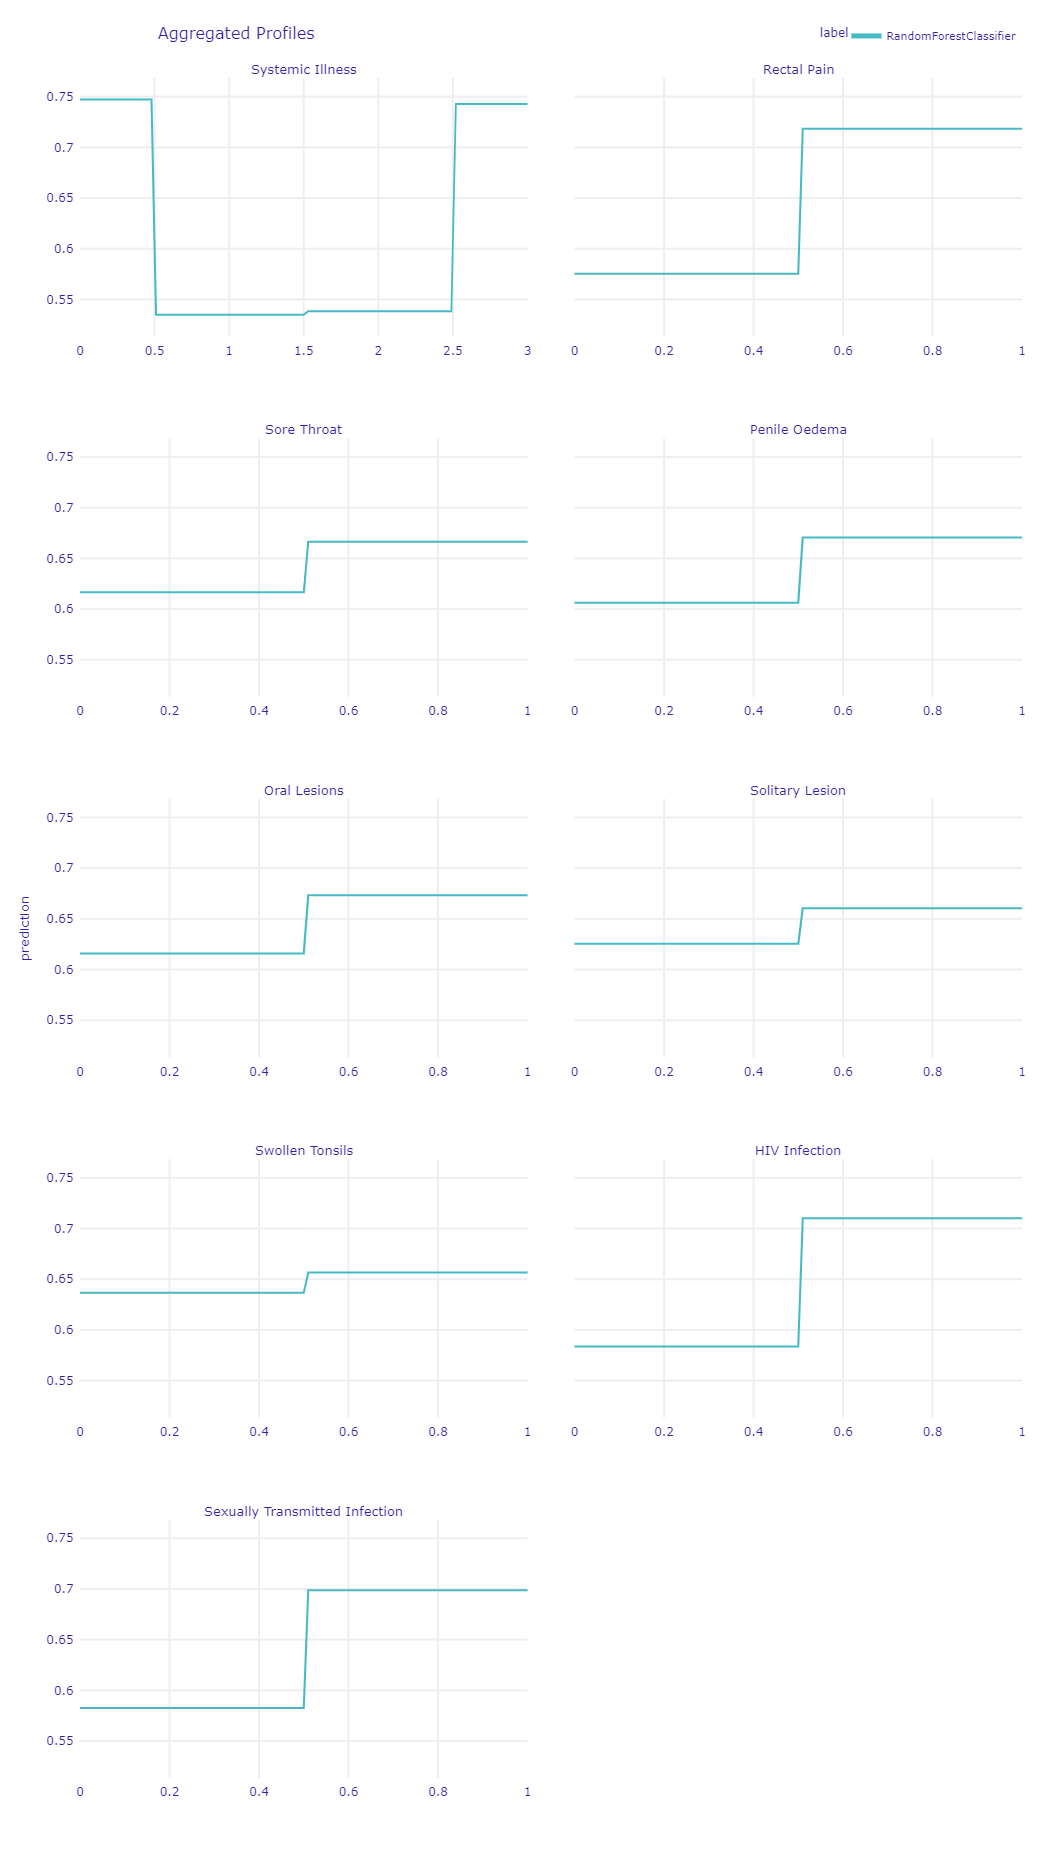

In [32]:
exp.model_profile().plot()

### It can be seen, that for the most important features from previous plot, lines are jumping more (especially for `Systemic Illness`). 

### Therefore, it can be concluded, that the difference between values at point 0 (False) and point 1 (True) are insufficient in cases of, e.g.: Swollen Tonsils, Solitarity Lesions.

### Hence, their impact on the final decision is not as large as in case of symptoms with great raggedness (e.g., Systematic Illness). 

## Impact of features on most representative samples of target class (patients infected with MonkeyPox and the ones that are not)

In [33]:
medoids = repres_samples(df_enc)

Breakdown for the most representative sample of target 0.0


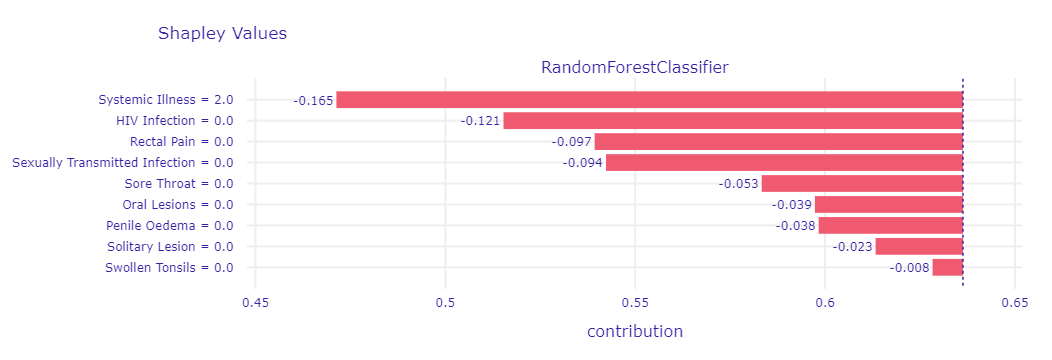

Breakdown for the most representative sample of target 1.0


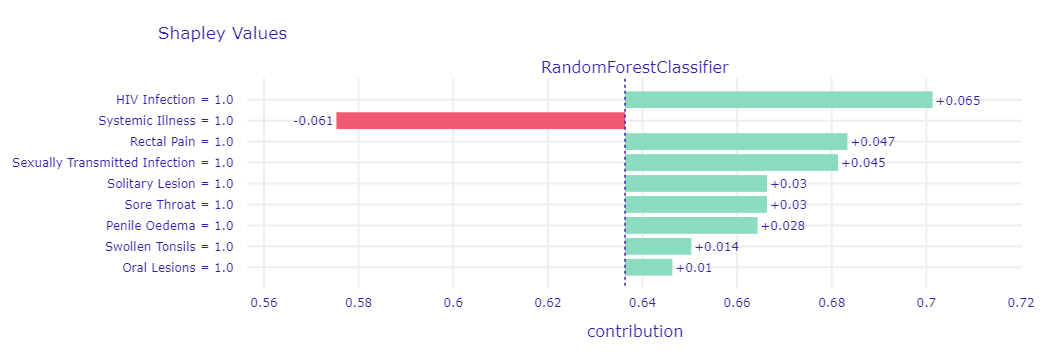

In [34]:
for key in medoids:
    print(f'Breakdown for the most representative sample of target {key}')
    exp.predict_parts(medoids[key], type='shap').plot()

#### Attributes to the value of the most representative samples

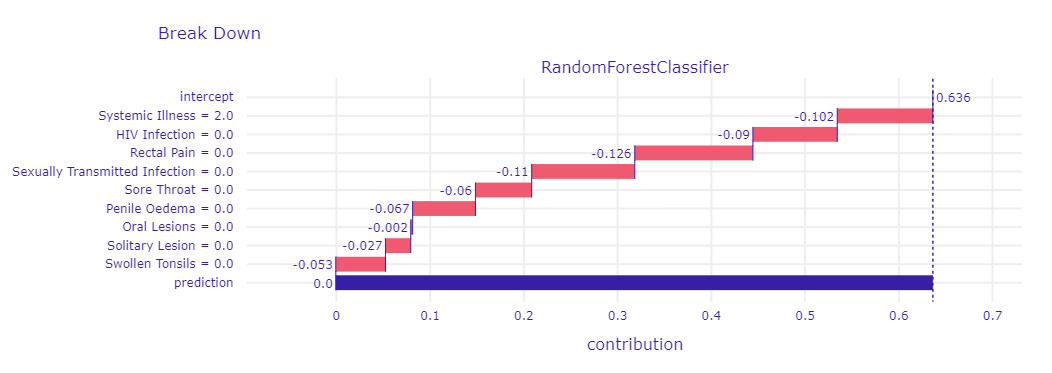

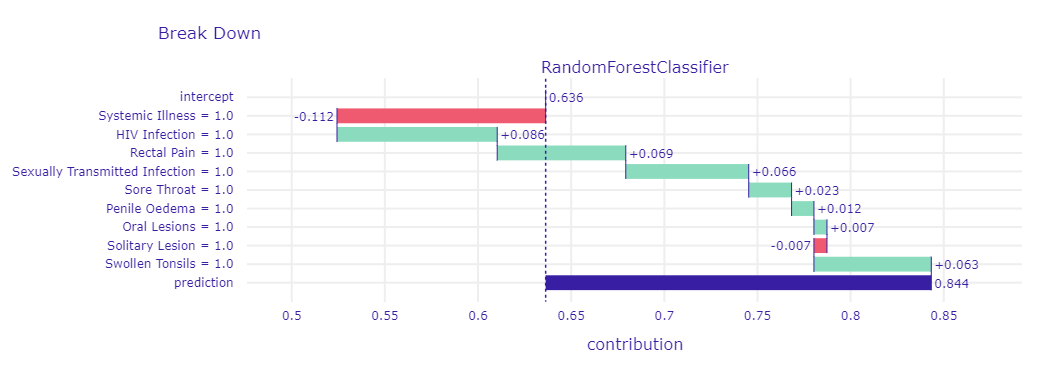

In [35]:
for key in medoids:
    exp.predict_parts(medoids[key], type='break_down_interactions').plot()

The plots above show the contribution of each feature w.r.t. the most representative sample (i.e., completely healthy patient and the infected one). 

### Model prediction of the most representative samples based on each feature

#### Note: Most representative samples are denoted as **dots** on the plots below.

Calculating ceteris paribus: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 46.17it/s]


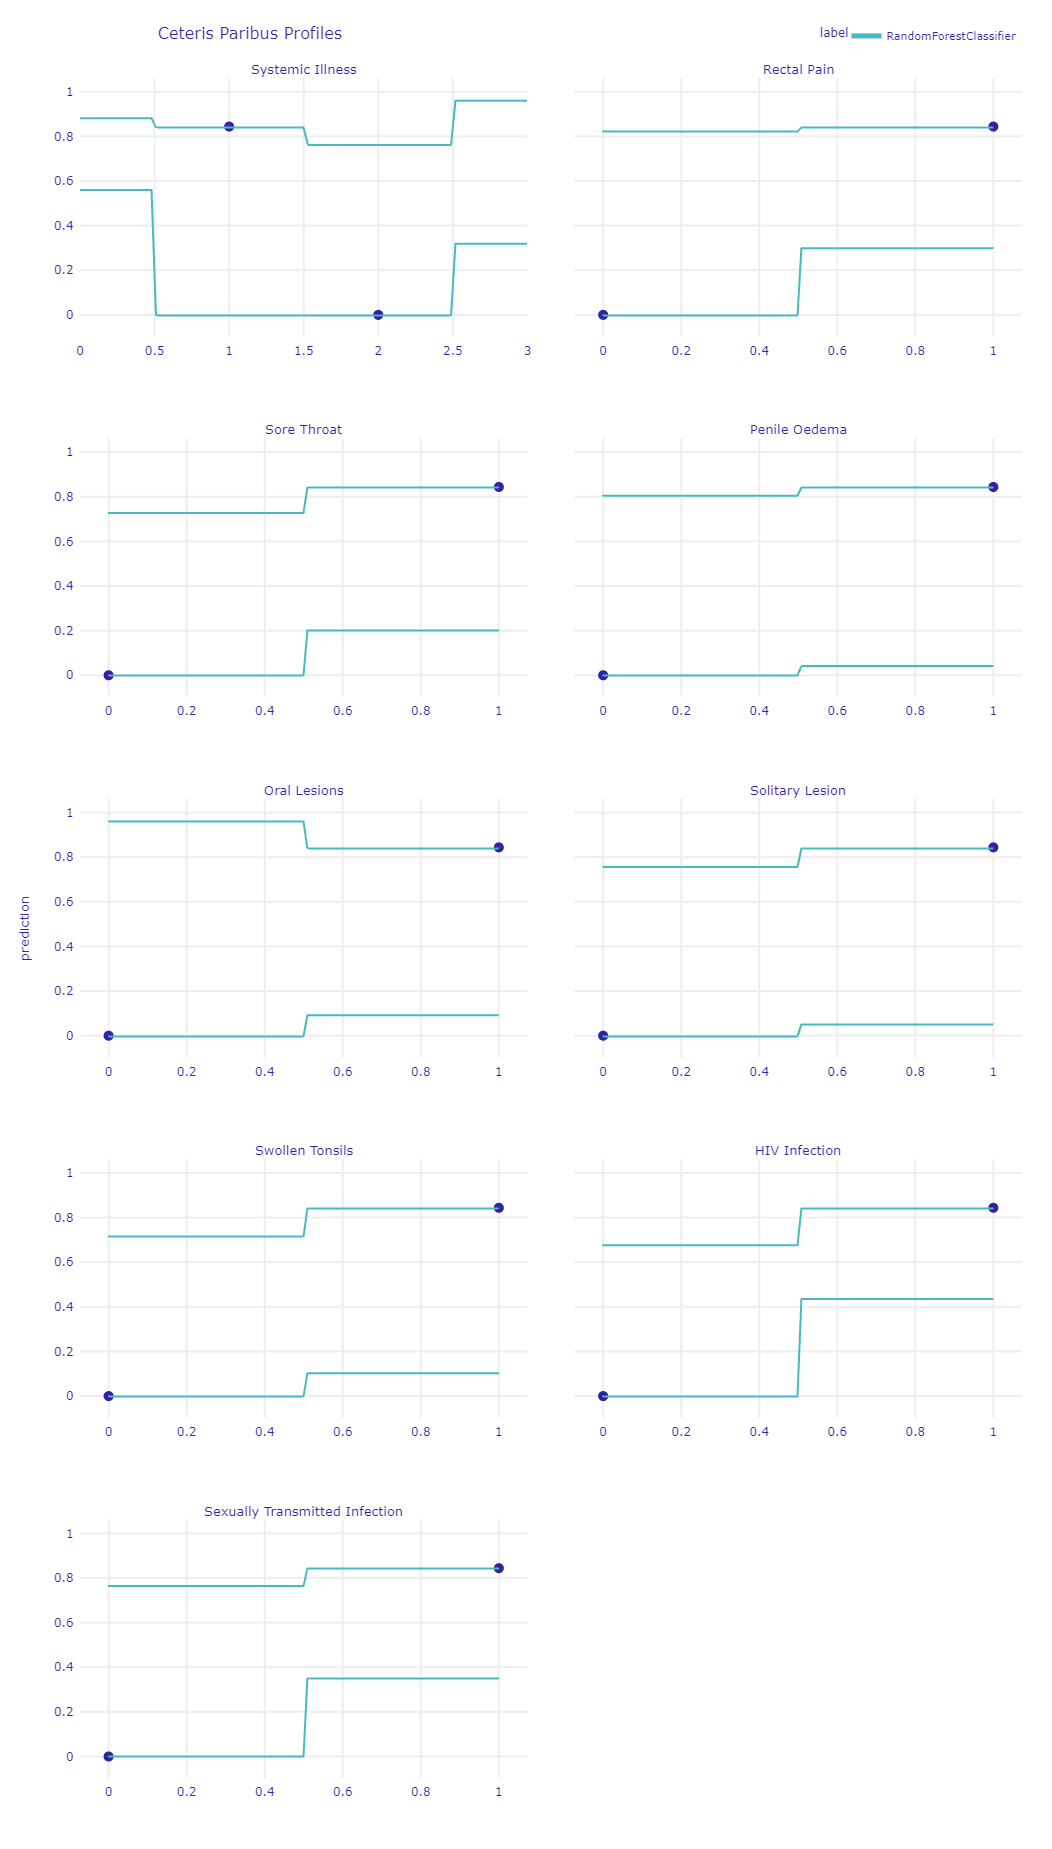

In [36]:
exp.predict_profile( np.array(list(medoids.values())) ).plot()

### Model evaluation
#### Note: We cannot use accuracy (due to imbalanced data). Therefore, roc-auc is used with 5-fold cross validation for better estimation.

In [37]:
score = cross_val_score(pipe, x, y, scoring='roc_auc',
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=17))

In [38]:
print(f'Roc-auc of the model: {np.mean(score)}')

Roc-auc of the model: 0.6680934276484868


#### It is better to concentrate on Recall value, in our case, since it's less harmful to predict MonkeyPox wrongly to someone not infected, having all the infected ones correctly classified.

In [39]:
df_enc.dropna(inplace=True)
x, y = df_enc.drop('target', axis=1), df_enc['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=17)

In [40]:
params = {'n_estimators': [10, 50, 100, 150],
          'max_features': [3, 6, 9],
          'min_samples_leaf': [1, 3, 5, 7],
          'max_depth': [3, 5, 10, 15, 20]}

gr = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
                  param_grid=params,
                  cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=17),
                  scoring='recall',
                  n_jobs=-1)

gr.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20],
                         'max_features': [3, 6, 9],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'n_estimators': [10, 50, 100, 150]},
             scoring='recall')

In [41]:
gr.best_score_, gr.best_params_

(0.9775011770172717,
 {'max_depth': 3,
  'max_features': 3,
  'min_samples_leaf': 1,
  'n_estimators': 100})

In [42]:
recall_score(y_test, gr.best_estimator_.predict(x_test))

0.9768025078369906

### Therefore, the Recall value above of around 95% was achieved having following parameters: 

- maximum depth: 3;

- maximum features: 3;

- minimum samples leaf: 1;

- number of estimators: 100.